<a href="https://colab.research.google.com/github/youssefbourais0310/Neural_Networks/blob/main/plant_meduim_data_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.listdir("/content/drive/MyDrive/dataset_anass"))

['.DS_Store', 'small_data.csv', 'train', 'test', 'meduim_data.csv', 'meduim_dataa.csv', 'mobilenet_1_0_224_tf.h5', 'models', '.ipynb_checkpoints', 'my_model.h5', 'TEST', 'mobilenet_CNN_meduim_data.h5']


In [3]:
import numpy as np
import pandas as pd
from keras.applications import xception
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import tensorflow as tf
import datetime as dt
import random
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import datetime
import tensorflow_hub as hub

In [202]:
CATEGORIES = ['Pelargonium_graveolens', 'Cirsium_arvense', 'Pelargonium_zonale', 'Mercurialis_annua', 'Phyllanthus_tenellus', 'Nephrolepis_exaltata', 'Vaccaria_hispanica',
              'Hyoseris_radiata']

NUM_CATEGORIES = len(CATEGORIES)
print(NUM_CATEGORIES)

8


In [203]:
SAMPLE_PER_CATEGORY = 400
data_dir = '/content/drive/MyDrive/dataset_anass'
train_dir = os.path.join(data_dir, '/content/drive/MyDrive/dataset_anass/train')
TEST_dir = os.path.join(data_dir, '/content/drive/MyDrive/dataset_anass/TEST')
test_dir = os.path.join(data_dir, '/content/drive/MyDrive/dataset_anass/test')

In [204]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Pelargonium_graveolens 331 images
Cirsium_arvense 276 images
Pelargonium_zonale 306 images
Mercurialis_annua 313 images
Phyllanthus_tenellus 103 images
Nephrolepis_exaltata 306 images
Vaccaria_hispanica 292 images
Hyoseris_radiata 144 images


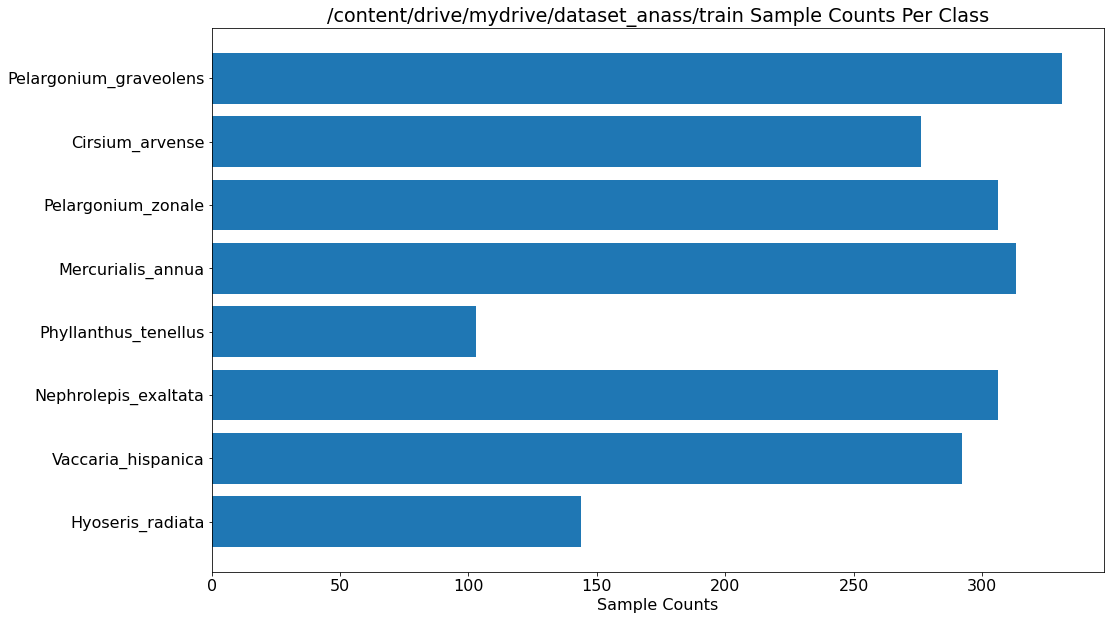

In [205]:
sample_counts= {}
train = "/content/drive/MyDrive/dataset_anass/train"

for i, d in enumerate([train]):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(d):
        train_class_path= os.path.join(d, f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    #fig, ax= plt.subplot(221+i)
    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

In [206]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['/content/drive/MyDrive/dataset_anass/train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
# train.head()
train.shape
train

,file,category_id,category
0,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
1,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
2,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
3,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
4,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
...,...,...,...
2066,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata
2067,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata
2068,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata
2069,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata


In [207]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape
train.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070],
           dtype='int64', length=2071)

In [208]:
test = []
for file in os.listdir(TEST_dir):
    test.append(['/content/drive/MyDrive/dataset_anass/TEST/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test

,filepath,file
0,/content/drive/MyDrive/dataset_anass/TEST/464b...,464baf0a50f7a4edc1a3fe9048930de24a3929a4.jpg
1,/content/drive/MyDrive/dataset_anass/TEST/300d...,300d23e03988932542b66a1525ab72ab97a4e40a.jpg
2,/content/drive/MyDrive/dataset_anass/TEST/0c81...,0c81296d2c5e192647dc391f6849bdef92cec537.jpg
3,/content/drive/MyDrive/dataset_anass/TEST/3302...,3302cb265ef781971f44536e1b90440805ecf4b0.jpg
4,/content/drive/MyDrive/dataset_anass/TEST/a517...,a517c1df2dd8da1c732528dc9ee2c68066925f48.jpg
...,...,...
594,/content/drive/MyDrive/dataset_anass/TEST/69c0...,69c06ed8fbe2b7bf3f62c406b66b48f7c2a14e69.jpg
595,/content/drive/MyDrive/dataset_anass/TEST/8a69...,8a6920023091ab28c58fbb93eacc28a2c0fc6015.jpg
596,/content/drive/MyDrive/dataset_anass/TEST/e4c8...,e4c8beedebd5dbbfef2c7ff310e3a047acf30a2e.jpg
597,/content/drive/MyDrive/dataset_anass/TEST/4f60...,4f60ee0704736db685c40923626096db71a4589f.jpg


In [209]:
test.shape

(599, 2)

In [210]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

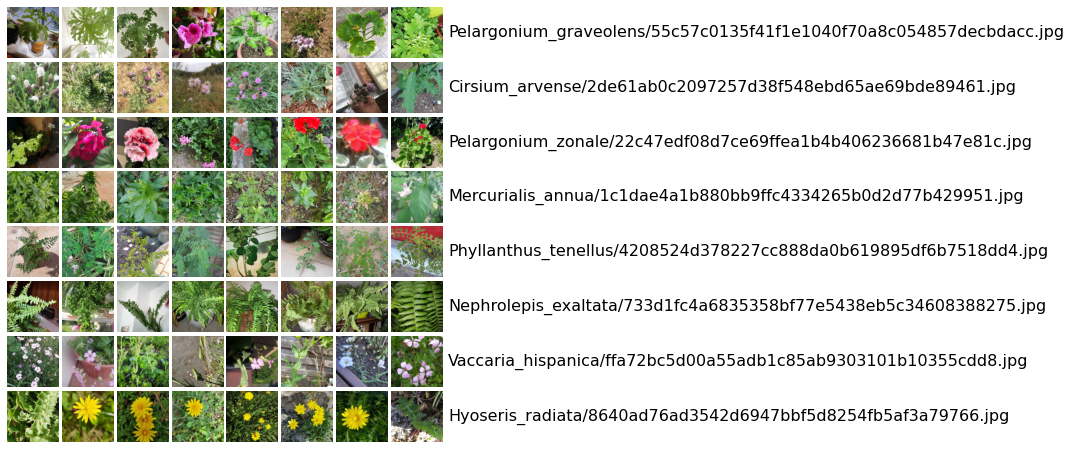

In [211]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/content/drive/MyDrive/dataset_anass/train/')[1], verticalalignment='center')
        i += 1
plt.show()

In [57]:
np.random.seed(seed=42)
rnd = np.random.random(len(train))
train_idx = rnd <= 0.8
valid_idx = rnd > 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1656, 415)

In [58]:
from keras.applications.mobilenet import MobileNet,preprocess_input, decode_predictions
INPUT_SIZE=224
POOLING='avg'  #A pooling layer is another building block of a CNN. Pooling. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network:The average value of all the pixels in the batch is selected.
x_train=np.zeros((len(train),INPUT_SIZE,INPUT_SIZE,3),dtype=np.float32)
for i,file in tqdm(enumerate(train['file'])):
    img = read_img(os.path.join(data_dir,file),(INPUT_SIZE,INPUT_SIZE))
    x=preprocess_input(np.expand_dims(img.copy(),axis=0)) #need to be changed for every model
    x_train[i]=x
print('Train image shape: {} size: {:,}'.format(x_train.shape,x_train.size))

2071it [00:18, 110.22it/s]

Train image shape: (2071, 224, 224, 3) size: 311,743,488


In [59]:
xtrain=x_train[train_idx]
xvalid=x_train[valid_idx]
print((xtrain.shape,xvalid.shape))

((1656, 224, 224, 3), (415, 224, 224, 3))


In [60]:
from keras.preprocessing import image
CNN_mobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # MobileNet(include_top=False, weights=None, input_shape=(224, 224, 3))

In [61]:
train_CNN = CNN_mobileNet.predict(xtrain, batch_size=32, verbose=1)
valid_CNN = CNN_mobileNet.predict(xvalid, batch_size=32, verbose=1)
print('CNN train  features shape: {} size: {:,}'.format(train_CNN.shape, train_CNN.size))
print('CNN valid  features shape: {} size: {:,}'.format(valid_CNN.shape, valid_CNN.size))

13/13 [==============================] - 13s 991ms/step
CNN train  features shape: (1656, 7, 7, 1024) size: 83,091,456
CNN valid  features shape: (415, 7, 7, 1024) size: 20,823,040


In [62]:
train_CNN=train_CNN.reshape(1656,50176)
valid_CNN=valid_CNN.reshape(415,50176)

In [63]:
import keras
ytr_labels = tf.keras.utils.to_categorical(ytr, num_classes=8) #Converts a class vector (integers) to binary class matrix.
yv_labels = tf.keras.utils.to_categorical(yv, num_classes=8)

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=50176, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=8))
model.add(Activation('softmax'))


# model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# model.summary()


 # compile the model 
model.compile(
              loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              50177000  
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 150)               75150     
                                                                 
 dense_7 (Dense)             (None, 8)                 1208      
                                                                 
 activation_1 (Activation)   (None, 8)                 0         
                                                                 
Total params: 50,753,858
Trainable params: 50,753,858
Non-trainable params: 0
_________________________________________________________________


In [66]:
full_model = model.fit(train_CNN,ytr_labels, epochs=16, batch_size=32,validation_data=(valid_CNN, yv_labels))

Epoch 1/16
52/52 [==============================] - 17s 310ms/step - loss: 1.4403 - accuracy: 0.5592 - val_loss: 0.9567 - val_accuracy: 0.7373
Epoch 2/16
52/52 [==============================] - 16s 302ms/step - loss: 0.6982 - accuracy: 0.8001 - val_loss: 0.6212 - val_accuracy: 0.8048
Epoch 3/16
52/52 [==============================] - 16s 304ms/step - loss: 0.2683 - accuracy: 0.9450 - val_loss: 0.5099 - val_accuracy: 0.8337
Epoch 4/16
52/52 [==============================] - 16s 303ms/step - loss: 0.0953 - accuracy: 0.9813 - val_loss: 0.4610 - val_accuracy: 0.8386
Epoch 5/16
52/52 [==============================] - 16s 300ms/step - loss: 0.0261 - accuracy: 0.9982 - val_loss: 0.5206 - val_accuracy: 0.8458
Epoch 6/16
52/52 [==============================] - 16s 302ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.4816 - val_accuracy: 0.8747
Epoch 7/16
52/52 [==============================] - 15s 298ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.4996 - val_accuracy: 0.8747

In [67]:
# evaluate the model
scores = model.evaluate(valid_CNN, yv_labels)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

13/13 [==============================] - 2s 178ms/step - loss: 0.5644 - accuracy: 0.8723
accuracy: 87.23%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


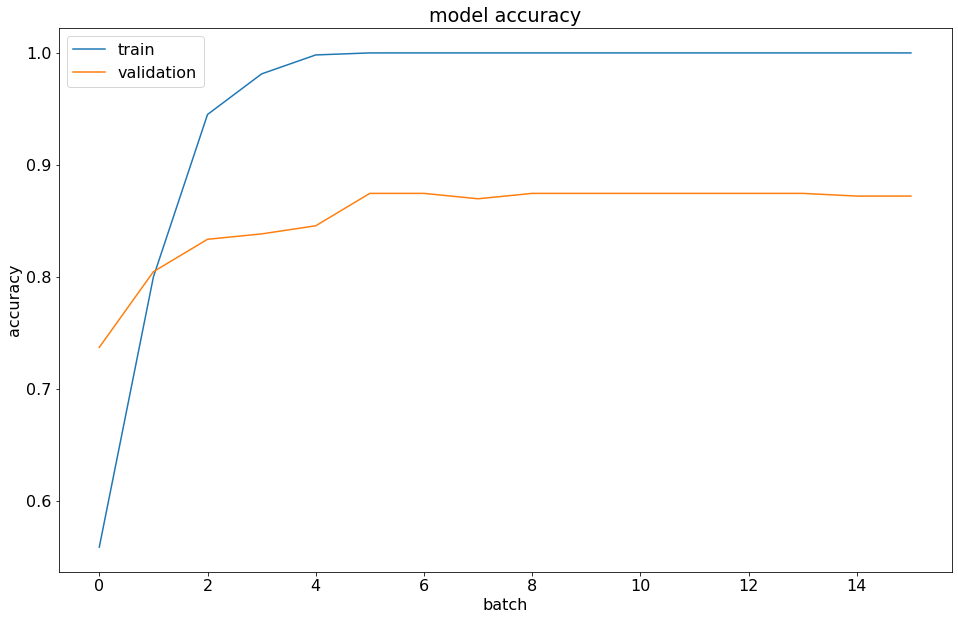

In [114]:
print(full_model.history.keys())
plt.plot(full_model.history['accuracy'])
plt.plot(full_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
model.save_weights('fc_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


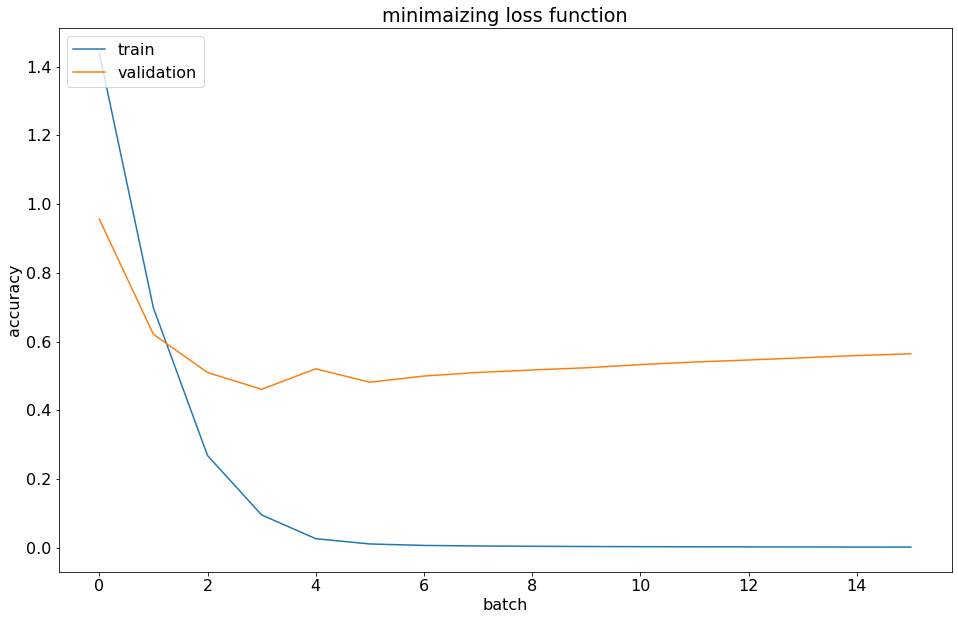

In [115]:
print(full_model.history.keys())
plt.plot(full_model.history['loss'])
plt.plot(full_model.history['val_loss'])
plt.title('minimaizing loss function')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
model.save_weights('fc_model.h5')

In [70]:
# make a prediction on the validation data (not used to train on ) 
predictions = model.predict(valid_CNN, verbose=1)
predictions

13/13 [==============================] - 1s 94ms/step


array([[9.9886298e-01, 1.1821835e-04, 2.6829666e-04, ..., 1.5071538e-04,
        1.1532266e-04, 2.2929620e-04],
       [8.4134167e-01, 8.5025543e-04, 1.4839874e-01, ..., 1.3270939e-03,
        5.1277285e-03, 5.0512713e-04],
       [9.9879467e-01, 8.4923086e-05, 2.7363095e-04, ..., 1.4197656e-04,
        1.5006213e-04, 2.4901793e-04],
       ...,
       [4.7374752e-04, 6.2947563e-04, 2.3000120e-04, ..., 3.5024085e-04,
        3.9928101e-04, 9.9730104e-01],
       [9.8785526e-01, 1.2502698e-03, 1.1906931e-03, ..., 6.6997216e-04,
        1.8992330e-04, 5.3082900e-03],
       [5.1468785e-04, 3.3525345e-04, 1.1036866e-03, ..., 4.0902360e-03,
        4.6110104e-04, 9.7494666e-03]], dtype=float32)

In [71]:
predictions[1]

array([8.4134167e-01, 8.5025543e-04, 1.4839874e-01, 4.5249041e-04,
       1.9968823e-03, 1.3270939e-03, 5.1277285e-03, 5.0512713e-04],
      dtype=float32)

In [72]:
predictions.shape

(415, 8)

In [213]:
# first predction 
index = 0
print(predictions[index])
print(f"Max value (probability of prediction): { np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index : {np.argmax(predictions[index])}")
print(f"Predicted label:{CATEGORIES[np.argmax(predictions[index])]}")

[9.9886298e-01 1.1821835e-04 2.6829666e-04 1.7406212e-04 8.1049839e-05
 1.5071538e-04 1.1532266e-04 2.2929620e-04]
Max value (probability of prediction): 0.9988629817962646
Sum:0.9999999403953552
Max index : 0
Predicted label:Pelargonium_graveolens


In [214]:
CATEGORIES[0]

'Pelargonium_graveolens'

## saving and reloading a trained model 

In [90]:
model.save('/content/drive/MyDrive/dataset_anass/models/mobilenet_CNN_meduim_dataa.h5')

In [91]:
 model_path ="/content/drive/MyDrive/dataset_anass/models/mobilenet_CNN_meduim_dataa.h5"
 model_load = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})

In [101]:
# load test image filenames
test_path = "/content/drive/MyDrive/dataset_anass/TEST"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/dataset_anass/TEST464baf0a50f7a4edc1a3fe9048930de24a3929a4.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST300d23e03988932542b66a1525ab72ab97a4e40a.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST0c81296d2c5e192647dc391f6849bdef92cec537.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST3302cb265ef781971f44536e1b90440805ecf4b0.jpg',
 '/content/drive/MyDrive/dataset_anass/TESTa517c1df2dd8da1c732528dc9ee2c68066925f48.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST1388a1a9267e8095d7205bb89b488d06637a4b78.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST42ae0d5bbd08cc1550a2536db0da98feee8a447a.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST727845ea6c61e3eaf4e6cf5f68fd2540db916127.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST6900b1638a2530ea88312a6872178931647a52a5.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST7a2c59e844aacae89fd240c66fedade8ad8cc001.jpg']

In [102]:
len(test_filenames)

599

In [116]:
# #make prdictions on test data batch using the loaded full model
# test_predictions = model_load.predict(test,
#                                              verbose = 1)

..........................

In [155]:
test2 = []
for file in os.listdir(TEST_dir):
    test2.append(['/content/drive/MyDrive/dataset_anass/TEST/{}'.format(file),file])
test2=pd.DataFrame(test2,columns=['file_path','file'])
test2

,file_path,file
0,/content/drive/MyDrive/dataset_anass/TEST/464b...,464baf0a50f7a4edc1a3fe9048930de24a3929a4.jpg
1,/content/drive/MyDrive/dataset_anass/TEST/300d...,300d23e03988932542b66a1525ab72ab97a4e40a.jpg
2,/content/drive/MyDrive/dataset_anass/TEST/0c81...,0c81296d2c5e192647dc391f6849bdef92cec537.jpg
3,/content/drive/MyDrive/dataset_anass/TEST/3302...,3302cb265ef781971f44536e1b90440805ecf4b0.jpg
4,/content/drive/MyDrive/dataset_anass/TEST/a517...,a517c1df2dd8da1c732528dc9ee2c68066925f48.jpg
...,...,...
594,/content/drive/MyDrive/dataset_anass/TEST/69c0...,69c06ed8fbe2b7bf3f62c406b66b48f7c2a14e69.jpg
595,/content/drive/MyDrive/dataset_anass/TEST/8a69...,8a6920023091ab28c58fbb93eacc28a2c0fc6015.jpg
596,/content/drive/MyDrive/dataset_anass/TEST/e4c8...,e4c8beedebd5dbbfef2c7ff310e3a047acf30a2e.jpg
597,/content/drive/MyDrive/dataset_anass/TEST/4f60...,4f60ee0704736db685c40923626096db71a4589f.jpg


In [159]:
data_dir1 = '/content/drive/MyDrive/dataset_anass/TEST/'

In [187]:
x_test = np.zeros((len(test2), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(test2['file_path'])):
    img = read_img(os.path.join(data_dir,file), (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))


599it [00:06, 87.30it/s] 

test Images shape: (599, 224, 224, 3) size: 90,166,272


In [173]:
test_x_predict = CNN_mobileNet.predict(x_test, batch_size=32, verbose=1)
print('Test CNN features shape: {} size: {:,}'.format(test_x_predict.shape, test_x_predict.size))

19/19 [==============================] - 20s 1s/step
Test CNN features shape: (599, 7, 7, 1024) size: 30,055,424


In [174]:
test_x_predict=test_x_predict.reshape(599,50176)

In [175]:
test_preds = model.predict(test_x_predict)

In [176]:
np.argmax(test_preds,axis=1).shape

(599,)

In [177]:
test_preds[:10]

array([[4.5226386e-04, 3.2502914e-05, 9.9892199e-01, 1.7508391e-05,
        1.9968981e-04, 7.1664428e-05, 2.0763127e-04, 9.6671029e-05],
       [2.1191746e-01, 9.7187760e-04, 7.0814288e-01, 2.1128777e-02,
        2.4329124e-02, 1.9479017e-03, 9.0942560e-03, 2.2467662e-02],
       [2.6492897e-02, 3.6505298e-04, 9.6865070e-01, 1.6440400e-04,
        3.4069945e-04, 4.1660946e-04, 3.2540276e-03, 3.1557123e-04],
       [6.0209760e-04, 4.6199631e-05, 9.9874997e-01, 1.5583657e-05,
        1.8674698e-04, 8.4382918e-05, 2.3223137e-04, 8.2649851e-05],
       [3.8640123e-04, 8.4037769e-05, 9.9801803e-01, 3.6779580e-05,
        4.8995967e-04, 7.8885219e-05, 5.1497150e-04, 3.9094576e-04],
       [5.7054142e-04, 3.4146895e-05, 9.9882263e-01, 1.6803548e-05,
        1.9815598e-04, 7.5160970e-05, 1.9857424e-04, 8.3932522e-05],
       [4.4954210e-04, 3.8269223e-05, 9.9874818e-01, 1.8837231e-05,
        2.5845933e-04, 6.9242116e-05, 3.1857539e-04, 9.8835197e-05],
       [7.6495674e-03, 8.8026332e-05, 9.9

In [178]:
test_pred_one = np.argmax(test_preds,axis=1)
test['category_id'] = test_pred_one
test['species'] = [CATEGORIES[c] for c in test_pred_one]
test[['file', 'species']].to_csv('submission.csv', index=False)

In [189]:
test

,filepath,file,category_id,species
0,/content/drive/MyDrive/dataset_anass/TEST/464b...,464baf0a50f7a4edc1a3fe9048930de24a3929a4.jpg,2,Pelargonium_zonale
1,/content/drive/MyDrive/dataset_anass/TEST/300d...,300d23e03988932542b66a1525ab72ab97a4e40a.jpg,2,Pelargonium_zonale
2,/content/drive/MyDrive/dataset_anass/TEST/0c81...,0c81296d2c5e192647dc391f6849bdef92cec537.jpg,2,Pelargonium_zonale
3,/content/drive/MyDrive/dataset_anass/TEST/3302...,3302cb265ef781971f44536e1b90440805ecf4b0.jpg,2,Pelargonium_zonale
4,/content/drive/MyDrive/dataset_anass/TEST/a517...,a517c1df2dd8da1c732528dc9ee2c68066925f48.jpg,2,Pelargonium_zonale
...,...,...,...,...
594,/content/drive/MyDrive/dataset_anass/TEST/69c0...,69c06ed8fbe2b7bf3f62c406b66b48f7c2a14e69.jpg,3,Mercurialis_annua
595,/content/drive/MyDrive/dataset_anass/TEST/8a69...,8a6920023091ab28c58fbb93eacc28a2c0fc6015.jpg,3,Mercurialis_annua
596,/content/drive/MyDrive/dataset_anass/TEST/e4c8...,e4c8beedebd5dbbfef2c7ff310e3a047acf30a2e.jpg,3,Mercurialis_annua
597,/content/drive/MyDrive/dataset_anass/TEST/4f60...,4f60ee0704736db685c40923626096db71a4589f.jpg,3,Mercurialis_annua
